In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter


In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Pre-processamento

In [0]:
df = pd.read_csv('USvideos.csv')

In [0]:
df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [0]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


In [0]:
def count_unique(x):
  for col in x.columns:
    print(f'{col}: {x[col].nunique()}')

In [0]:
count_unique(df)

video_id: 6351
trending_date: 205
title: 6455
channel_title: 2207
category_id: 16
publish_time: 6269
tags: 6055
views: 40478
likes: 29850
dislikes: 8516
comment_count: 13773
thumbnail_link: 6352
comments_disabled: 2
ratings_disabled: 2
video_error_or_removed: 2
description: 6901


In [0]:
# Drop columns with no important information in our analysis:
#thumbnail_link: link to small image which identify the video in the search results

df.drop(columns='thumbnail_link', inplace=True)
print(df.columns)

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description'],
      dtype='object')


In [0]:
# Read json with category_id names and assign the names in new dataframe column 

import json

# open json file with category names
with open('US_category_id.json', 'r') as f:
  categ_us = json.load(f)

categ_dic = {}

for k in categ_us['items']:
  categ_dic[k['id']]= k['snippet']['title']

#print(categ_dic)

# Creating new column with category names
temp = df.category_id.copy()
temp = temp.astype('str')
df['category_name'] = temp.map(categ_dic)

#print(df.loc[:10, ['category_id', 'category_name']])



Text(0, 0.5, 'Category')

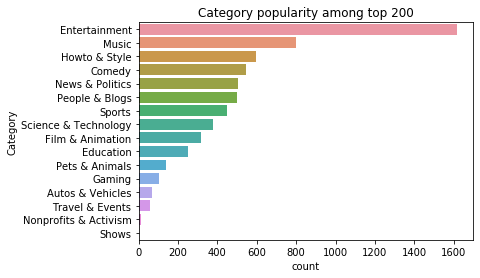

In [0]:
df2 = df.copy()
df2.drop_duplicates('video_id', inplace=True)
sns.countplot(y='category_name', data=df2, order=df2.category_name.value_counts().index )
plt.title('Category popularity among top 200')
plt.ylabel('Category')

### Temporal distributions

Total samples per year:
 2018    31349
2017     9600
Name: trending_date, dtype: int64


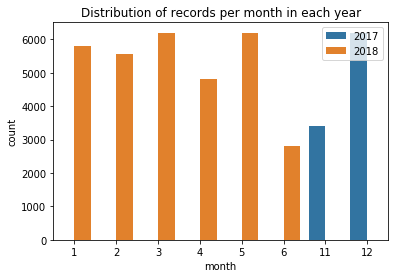

In [0]:
# Processing the time feature

df.trending_date = pd.to_datetime(df.trending_date, format='%y.%d.%m')

year_counts = df.trending_date.dt.year.value_counts()
print('Total samples per year:\n', year_counts) 

df['year'] = df.trending_date.dt.year
df['month'] = df.trending_date.dt.month

# Plot distribution of records per time 
sns.countplot(data=df, x = 'month', hue='year')
plt.title('Distribution of records per month in each year')
plt.legend(['2017', '2018'])


## Popularity

Text(0.5, 1.0, 'Most viewed videos')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

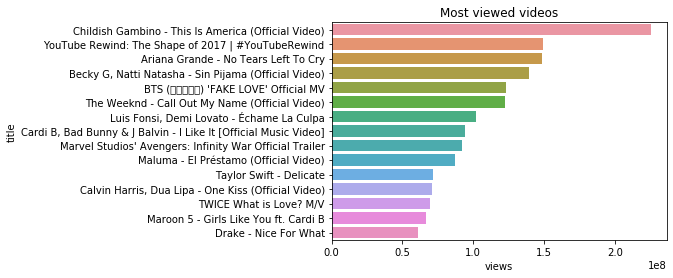

In [0]:
# Per views
df2 = df.copy()

df2.sort_values('views', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

sns.barplot(y='title', x='views', data=df2.iloc[:15])
plt.title('Most viewed videos')

#TODO: warnings caused by presence of not roman font!

In [0]:
df2.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
38547,VYOjWnS4cMY,2018-06-02,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,False,False,False,“This is America” by Childish Gambino http://s...,Music,2018,6
6181,FlsCjmMhFmw,2017-12-14,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",149376127,3093544,1643059,810698,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
34708,ffxKSjUwKdU,2018-05-14,Ariana Grande - No Tears Left To Cry,ArianaGrandeVevo,10,2018-04-20T04:00:03.000Z,"Ariana|""Grande""|""No""|""Tears""|""Left""|""To""|""Cry""...",148689896,3094021,129502,242039,False,False,False,No Tears Left To Cry (Official Video)Song Avai...,Music,2018,5
34888,zEf423kYfqk,2018-05-15,"Becky G, Natti Natasha - Sin Pijama (Official ...",BeckyGVEVO,10,2018-04-20T10:40:51.000Z,"Becky G|""Natti Natasha""|""Natti Natasha Music""|...",139334502,1425496,119798,83941,False,False,False,Becky G & Natti Natasha – “Sin Pijama”NUEVO SE...,Music,2018,5
38273,7C2z4GqqS5E,2018-06-01,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",123010920,5613827,206892,1228655,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Music,2018,6
34747,M4ZoCHID9GI,2018-05-14,The Weeknd - Call Out My Name (Official Video),TheWeekndVEVO,10,2018-04-12T16:00:04.000Z,"The|""Weeknd""|""Call""|""Out""|""My""|""Name""",122544931,1427436,40837,55320,False,False,False,Call Out My Name (Official Video)Taken from th...,Music,2018,5
2587,TyHvyGVs42U,2017-11-26,"Luis Fonsi, Demi Lovato - Échame La Culpa",LuisFonsiVEVO,10,2017-11-17T05:00:01.000Z,"Luis|""Fonsi""|""Demi""|""Lovato""|""Échame""|""La""|""Cu...",102012605,2376636,117196,134224,False,False,False,“Échame La Culpa” disponible ya en todas las p...,Music,2017,11
40869,xTlNMmZKwpA,2018-06-14,"Cardi B, Bad Bunny & J Balvin - I Like It [Off...",Cardi B,10,2018-05-29T14:05:10.000Z,"Cardi B|""I Like It""|""Invasion of Privacy""|""Bad...",94254507,1816753,102474,101077,False,False,False,"Cardi B, Bad Bunny & J Balvin - I Like It from...",Music,2018,6
4997,6ZfuNTqbHE8,2017-12-08,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",91933007,2625661,53709,350458,False,False,False,There was an idea… Avengers: Infinity War. In ...,Entertainment,2017,12
25947,-BQJo3vK8O8,2018-03-25,Maluma - El Préstamo (Official Video),MalumaVEVO,10,2018-03-09T11:00:01.000Z,"Maluma Music|""Maluma Official Video""|""Maluma V...",87264467,815369,71494,35945,False,False,False,Maluma - El Prestamo (Official Music Video)\nE...,Music,2018,3


In [0]:
# Per likes
df2 = df.copy()

df2.sort_values('likes', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

df2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
38273,7C2z4GqqS5E,2018-06-01,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",123010920,5613827,206892,1228655,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Music,2018,6
38547,VYOjWnS4cMY,2018-06-02,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,False,False,False,“This is America” by Childish Gambino http://s...,Music,2018,6
34708,ffxKSjUwKdU,2018-05-14,Ariana Grande - No Tears Left To Cry,ArianaGrandeVevo,10,2018-04-20T04:00:03.000Z,"Ariana|""Grande""|""No""|""Tears""|""Left""|""To""|""Cry""...",148689896,3094021,129502,242039,False,False,False,No Tears Left To Cry (Official Video)Song Avai...,Music,2018,5
6181,FlsCjmMhFmw,2017-12-14,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",149376127,3093544,1643059,810698,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
3581,kTlv5_Bs8aw,2017-12-01,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10,2017-11-24T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",36857298,2729292,47896,546100,False,False,False,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Music,2017,12


In [0]:
# Per dislikes
df2 = df.copy()

df2.sort_values('dislikes', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

df2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
11323,QwZT7T-TXT0,2018-01-09,So Sorry.,Logan Paul Vlogs,24,2018-01-02T16:42:21.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""o...",37539570,1402578,1674420,1361580,False,False,False,NaN,Entertainment,2018,1
6181,FlsCjmMhFmw,2017-12-14,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",149376127,3093544,1643059,810698,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
15571,oWjxSkJpxFU,2018-02-01,Suicide: Be Here Tomorrow.,Logan Paul Vlogs,29,2018-01-24T18:30:01.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""l...",24286474,1988746,497847,658130,False,False,False,National Suicide Prevention Lifeline\nCall 1-8...,Nonprofits & Activism,2018,2
38547,VYOjWnS4cMY,2018-06-02,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,10,2018-05-06T04:00:07.000Z,"Childish Gambino|""Rap""|""This Is America""|""mcDJ...",225211923,5023450,343541,517232,False,False,False,“This is America” by Childish Gambino http://s...,Music,2018,6
17063,_5d-sQ7Fh5M,2018-02-09,LOGAN PAUL IS BACK!,Logan Paul Vlogs,24,2018-02-04T22:02:27.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""o...",14161833,1216340,291900,436698,False,False,False,Do It Different. Be a Maverick ► https://ShopL...,Entertainment,2018,2


In [0]:
# Per comments
df2 = df.copy()

df2.sort_values('comment_count', ascending=False, inplace=True)
df2.drop_duplicates('video_id', inplace=True)

df2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,year,month
11323,QwZT7T-TXT0,2018-01-09,So Sorry.,Logan Paul Vlogs,24,2018-01-02T16:42:21.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""o...",37539570,1402578,1674420,1361580,False,False,False,NaN,Entertainment,2018,1
38273,7C2z4GqqS5E,2018-06-01,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",123010920,5613827,206892,1228655,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,Music,2018,6
5020,FlsCjmMhFmw,2017-12-09,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",75969469,2251797,1127798,827755,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",Entertainment,2017,12
15571,oWjxSkJpxFU,2018-02-01,Suicide: Be Here Tomorrow.,Logan Paul Vlogs,29,2018-01-24T18:30:01.000Z,"logan paul vlog|""logan paul""|""logan""|""paul""|""l...",24286474,1988746,497847,658130,False,False,False,National Suicide Prevention Lifeline\nCall 1-8...,Nonprofits & Activism,2018,2
3581,kTlv5_Bs8aw,2017-12-01,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,10,2017-11-24T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""",36857298,2729292,47896,546100,False,False,False,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,Music,2017,12


Text(0.5, 1.0, 'Channel popularity among top 200')

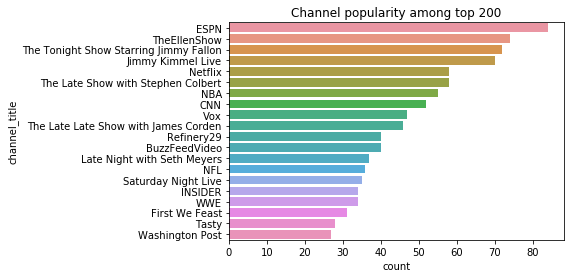

In [0]:
# Per channel
df2 = df.copy()

df2.drop_duplicates('video_id', inplace=True)

sns.countplot(y='channel_title', data=df2, order=df2.channel_title.value_counts().iloc[:20].index)
plt.title('Channel popularity among top 200')


In [0]:
# Divide per year 
df_2017 = df[df.trending_date.dt.year == 2017]
df_2018 = df[df.trending_date.dt.year == 2018]


Video popularity rank varies a lot between the months

In [0]:
# 2017
var = 'likes'
mon = 12 #11-12

In [0]:
df_2017.loc[df.trending_date.dt.month == mon, ['video_id', 'title', var]].groupby(['video_id', 'title']).sum().sort_values(var, ascending = False).head(10)

,,likes
video_id,title,
6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Official Trailer,19819535
FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRewind,19781372
SM1w9PEQOE8,Demi Lovato - Tell Me You Love Me,8379638
WS7f5xpGYn8,Katy Perry - Hey Hey Hey (Official),6776063
khPLWaBioOs,Logan Paul - SANTA DISS TRACK (Official Music Video),6354734
817P8W8-mGE,Ed Sheeran - Perfect Duet (with Beyoncé) [Official Audio],6047721
JcdLF6XQ0iw,PANCAKE ART CHALLENGE 4!!! Learn How To Make Mario Odyssey Star Wars Jedi Nintendo Food DIY Pancake,5996526
eiDiKwbGfIY,Ed Sheeran - Perfect Symphony (with Andrea Bocelli),5923033
l_lblj8Cq0o,"G-Eazy - No Limit REMIX ft. A$AP Rocky, Cardi B, French Montana, Juicy J, Belly",5520912


In [0]:
# 2018
var = 'likes'
mon = 1 # 1-6

In [0]:
df_2018.loc[df.trending_date.dt.month == mon, ['video_id', 'title', var]].groupby(['video_id', 'title']).sum().sort_values(var, ascending = False)[:10]

,,likes
video_id,title,
oWjxSkJpxFU,Suicide: Be Here Tomorrow.,12282280
dfnCAmr569k,"Taylor Swift - End Game ft. Ed Sheeran, Future",11127424
LsoLEjrDogU,Bruno Mars - Finesse (Remix) [Feat. Cardi B] [Official Video],9188754
QwZT7T-TXT0,So Sorry.,8495733
Mgfe5tIwOj0,Dua Lipa - IDGAF (Official Music Video),6866042
VRJmcxCrAOA,Real Life Trick Shots 2 | Dude Perfect,6206553
J41qe-TM1DY,JONGHYUN 종현 '빛이 나 (Shinin’)' MV,5722350
eACohWVwTOc,The Chainsmokers - Sick Boy,3030806
k5TqNsr6YuQ,Troye Sivan - My My My!,2965742


In [0]:
df['category_name'].value_counts()

Entertainment            9964
Music                    6472
Howto & Style            4146
Comedy                   3457
People & Blogs           3210
News & Politics          2487
Science & Technology     2401
Film & Animation         2345
Sports                   2174
Education                1656
Pets & Animals            920
Gaming                    817
Travel & Events           402
Autos & Vehicles          384
Nonprofits & Activism      57
Shows                      57
Name: category_name, dtype: int64

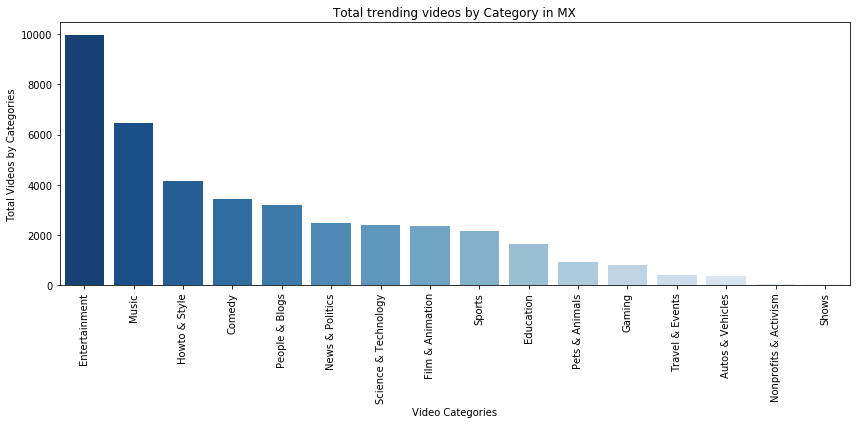

In [0]:
#POPULARIDADE DE VÍDEOS POR CATEGORIA
plt.figure(figsize=(12,6))
sns.countplot(x='category_name', data=df, palette='Blues_r', order=df['category_name'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Video Categories')
plt.ylabel('Total Videos by Categories')
plt.title('Total trending videos by Category in MX')
plt.tight_layout()
plt.show()

Percebe-se aqui que os vídeos de "Entertainment"(9.964) são os mais populares, seguido por "MUSIC"(6.472), que tbm é uma tendência e um tipo de entretenimento. Há aqui uma categoria que se chama "Howto & Style", sendo canais de ensino a estilização e possivelmente DIY, ou faça você mesmo, uma categoria um tanto quanto surpreendente.
A última categoria listada e com menos quantidade de diversidade, seria "Shows", talvez pela concorrência com a divulgação em televisão, ou pelo o fator humano, onde as pessoas acham mais interessante essa categoria sendo visualizada ao vivo (hypothesis)

In [0]:
df3 = df.copy()

In [0]:
df3['pub_day'] = df3['publish_time'].apply(lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d"). date().strftime('%a'))
df3['pub_hour'] = df3['publish_time'].apply(lambda x: x[11:13])
df3.drop(labels='publish_time', axis=1, inplace=True)

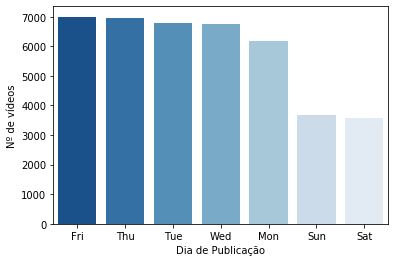

In [0]:
new_df = df3["pub_day"].value_counts()\
.to_frame().reset_index().rename(columns={"index": "pub_day", "pub_day" : "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="pub_day", y="No_of_videos", data=new_df, 
                palette='Blues_r', ax=ax)
_ = ax.set(xlabel="Dia de Publicação", ylabel="Nº de vídeos")

Conseguimos perceber aqui que nas sextas-feiras existe um grande índice de videos publicados, enquanto, sábados e domingos tem um menor índice de upload, refletindo diretamente na tendência e popularidade.

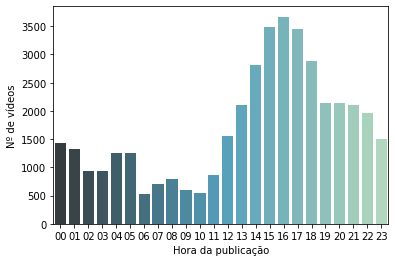

In [0]:
new_df = df3["pub_hour"].value_counts()\
.to_frame().reset_index().rename(columns={"index": "pub_hour", "pub_hour" : "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="pub_hour", y="No_of_videos", data=new_df, 
                palette='GnBu_d', ax=ax)
_ = ax.set(xlabel="Hora da publicação", ylabel="Nº de vídeos")

Conseguimos perceber aqui que entre 12:00AM - 16:00PM existe um índice muito alto de vídeos com mais popularidade sendo publicados. A partir das 17:00PM ele sofre uma queda drástica e se mantém constante até às 23:00 quando o índice começa a cair novamente, podemos perceber que entre 14 e 19:00PM apesar da queda.. entre 18 e 19:00 ainda são os melhores horários para upload.

In [0]:
#Vamos verificar as 30 palavras mais utilizados/comuns nos títulos, usando WordCloud vamos fazer uma nuvem de palavras
words = list(df['title'].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(30)

[('-', 11452),
 ('|', 10663),
 ('The', 5762),
 ('the', 3610),
 ('a', 2566),
 ('to', 2343),
 ('of', 2338),
 ('in', 2176),
 ('A', 2122),
 ('&', 2024),
 ('I', 1940),
 ('and', 1917),
 ('Video)', 1901),
 ('Trailer', 1868),
 ('How', 1661),
 ('with', 1655),
 ('2018', 1613),
 ('(Official', 1594),
 ('Official', 1554),
 ('on', 1552),
 ('To', 1397),
 ('You', 1254),
 ('My', 1080),
 ('for', 1020),
 ('ft.', 1017),
 ('In', 943),
 ('With', 897),
 ('Is', 828),
 ('at', 826),
 ('What', 773)]

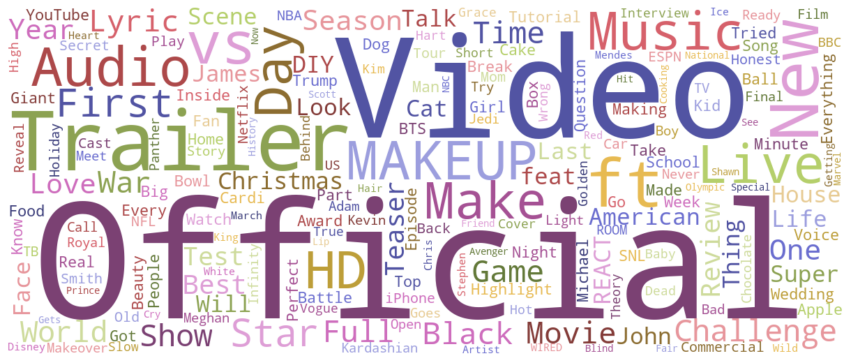

In [0]:
word_cloud = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))
plt.figure(figsize=(15,10))
plt.imshow(word_cloud, interpolation='bilinear')
_ = plt.axis("off")

Se retirarmos expessões comuns como "at", "the", "do", podemos perceber várias expressões comuns como "New", "Trailer", "VS", "Music", "Video", "Official", "Day" entre outras expressões mais utilizadas e que estão entre as mais populares.

In [0]:
#plt.figure(figsize=(15,10))
#sns.regplot(df3['views']/1000000, df3['likes']/1000, color='red')
#sns.regplot(df3['views']/1000000, df3['dislikes']/1000, color='blue')

#plt.title('Views vs Likes/Dislikes of Trending Videos')
#plt.xlabel('Views (in millions)')
#plt.ylabel('Likes/Dislikes (in thousands)')
#plt.legend(['Likes','Dislikes'])

#plt.show()
